# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [279]:
from typing import Iterable, List
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [280]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [281]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:

        loss = np.mean((X.dot(w) - y) ** 2)
        return loss

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:

        grad = 2 / X.shape[0] * X.T.dot(X.dot(w) - y)
        return grad

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [282]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [283]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w0 = np.copy(w_init)
    history = np.zeros((n_iterations, w_init.shape[0]))
    for i in range(n_iterations):
        grad = loss.calc_grad(X, y, w0)
        w0 = w0 - lr*grad
        history[i] = w0

    return history

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [284]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337) #не люблю я этот seed, или 42 или на 151 больше чем данный




n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [285]:

loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
#print(w_list)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))


155.26258214352075
0.8670644395649493


In [286]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)
            
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

In [287]:
n_iter = 1000

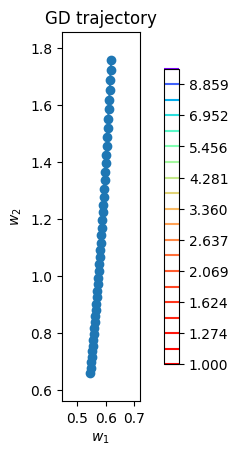

Final loss with lr=0.0001: 115.76116928160981


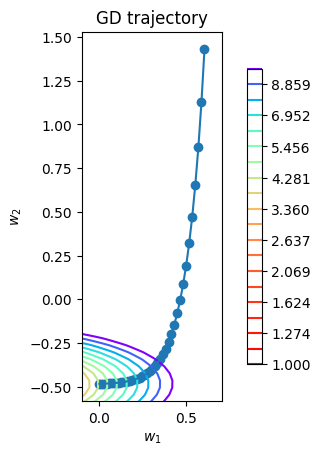

Final loss with lr=0.001: 4.326140711579451


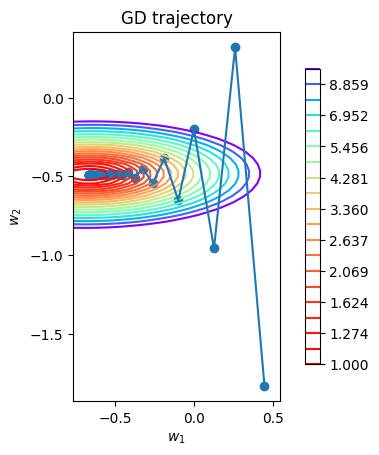

Final loss with lr=0.01: 0.8670719772817392


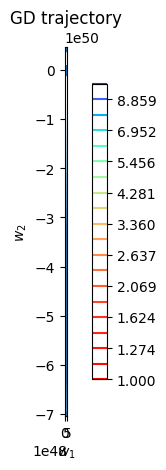

Final loss with lr=0.1: 3.95343394796037e+103


In [288]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

# Итерация по различным значениям learning rate
for lr in learning_rates:
    w_list = gradient_descent(w_init, X, y, loss, lr, num_steps)
    plot_gd(w_list, X, y, loss)
    print(f"Final loss with lr={lr}: {loss.calc_loss(X, y, w_list[-1])}")

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [289]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch = X[batch_indices]
    y_new = y[batch_indices]
    w0 = np.copy(w_init)
    history = np.zeros((n_iterations, w_init.shape[0]))
    for i in range(n_iterations):
        grad = loss.calc_grad(batch, y_new, w0)
        w0 = w0 - lr*grad
        history[i] = w0
    return history

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

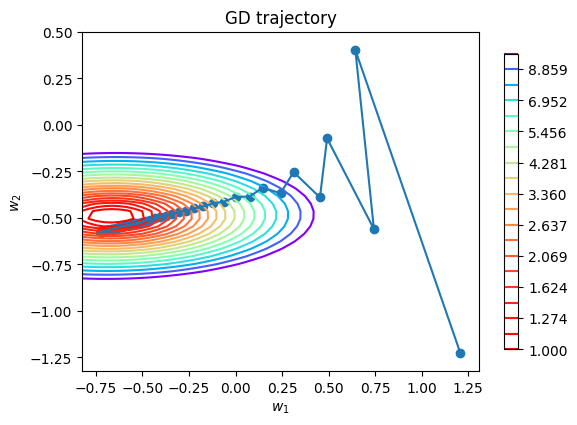

Final loss with lr=[0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001] and batch_size=[10, 50, 100, 150, 10, 50, 100, 150]: 1.4786509104426788


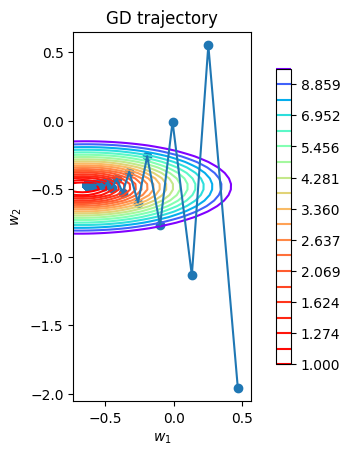

Final loss with lr=[0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001] and batch_size=[10, 50, 100, 150, 10, 50, 100, 150]: 0.9040516703782161


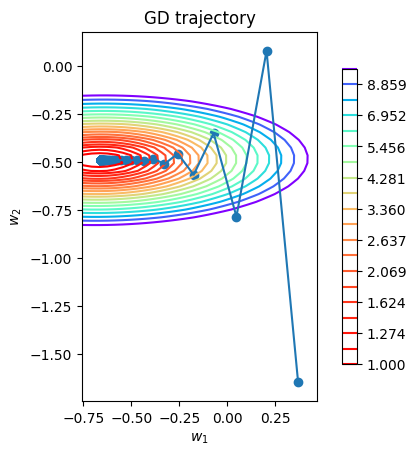

Final loss with lr=[0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001] and batch_size=[10, 50, 100, 150, 10, 50, 100, 150]: 0.868101212070488


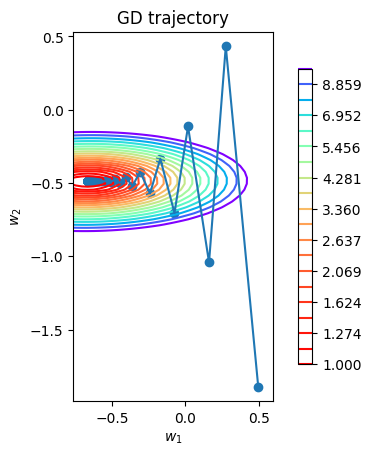

Final loss with lr=[0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001] and batch_size=[10, 50, 100, 150, 10, 50, 100, 150]: 0.8671449370433758


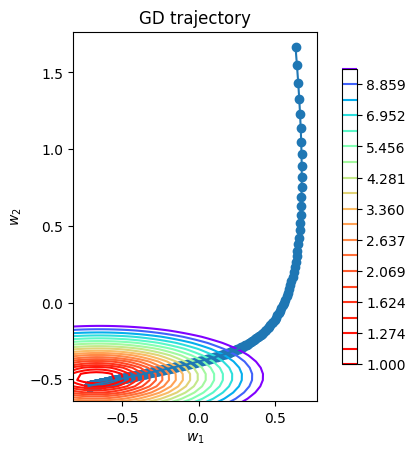

Final loss with lr=[0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001] and batch_size=[10, 50, 100, 150, 10, 50, 100, 150]: 1.1097596837932453


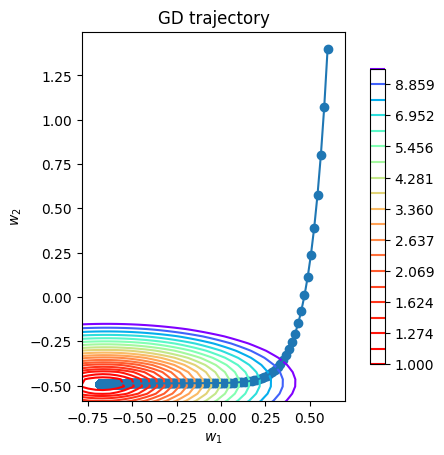

Final loss with lr=[0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001] and batch_size=[10, 50, 100, 150, 10, 50, 100, 150]: 0.8692148311891941


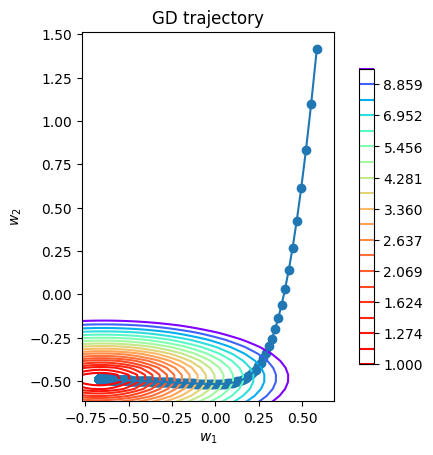

Final loss with lr=[0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001] and batch_size=[10, 50, 100, 150, 10, 50, 100, 150]: 0.8672331621214895


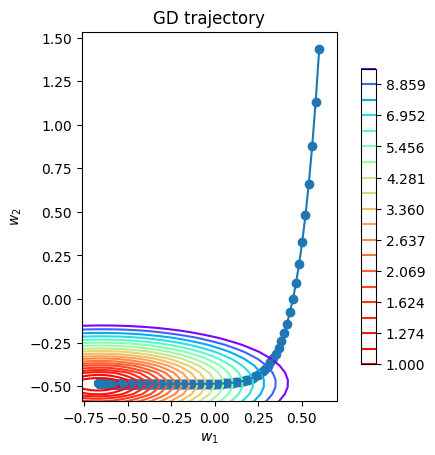

Final loss with lr=[0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001] and batch_size=[10, 50, 100, 150, 10, 50, 100, 150]: 0.8694356348014336


In [290]:


batch_size = [10, 50, 100, 150, 10, 50, 100, 150]
lr = [0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001]
n_iter = 1000

for i in range(len(batch_size)):
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr[i], batch_size[i], n_iter)
    plot_gd(w_list, X, y, loss)
    print(f"Final loss with lr={lr} and batch_size={batch_size}: {loss.calc_loss(X, y, w_list[-1])}")
    

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [291]:
def stochastic_gradient_descent_lr(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch = X[batch_indices]
    y_new = y[batch_indices]
    w0 = np.copy(w_init)
    lr0 = lr
    history = np.zeros((n_iterations, w_init.shape[0]))
    for i in range(n_iterations):
        grad = loss.calc_grad(batch, y_new, w0)
        w0 = w0 - lr0*grad
        lr0 = lr0*(1/(1+i))**p
        history[i] = w0
    return history

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

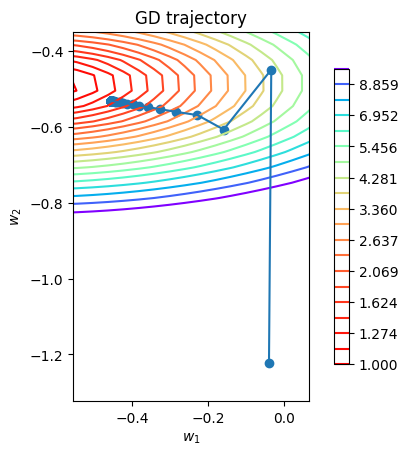

Final loss with lr=0.01 and batch_size=10: 1.3644448261908304


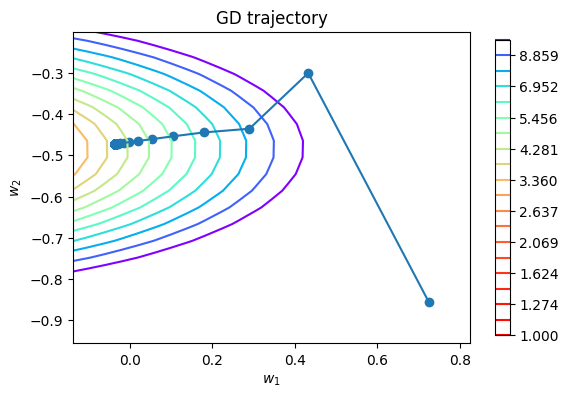

Final loss with lr=0.01 and batch_size=10: 3.9465429191465886


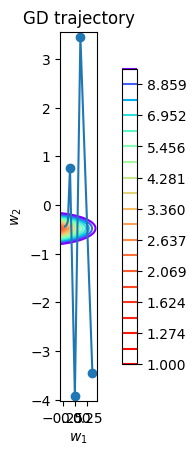

Final loss with lr=0.01 and batch_size=10: 2.6651790961612156


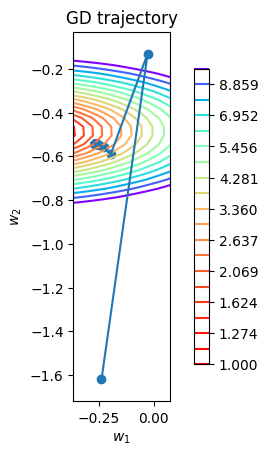

Final loss with lr=0.01 and batch_size=10: 2.3512747458525176


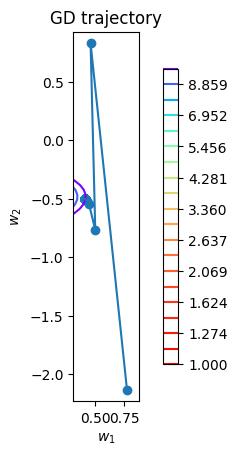

Final loss with lr=0.01 and batch_size=10: 9.921623355304037


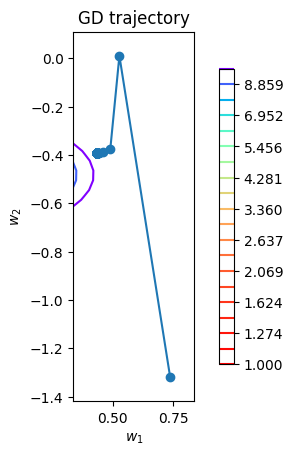

Final loss with lr=0.01 and batch_size=10: 10.878631825358376


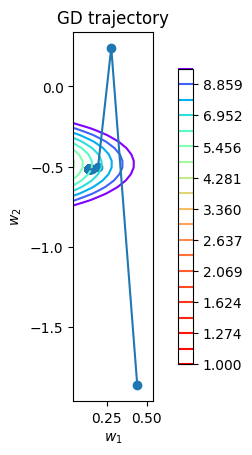

Final loss with lr=0.01 and batch_size=10: 6.017012248146154


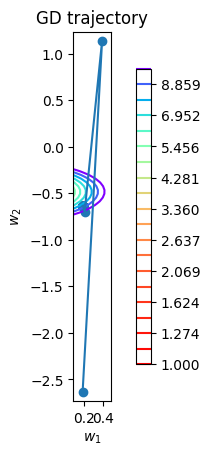

Final loss with lr=0.01 and batch_size=10: 8.308069763475917


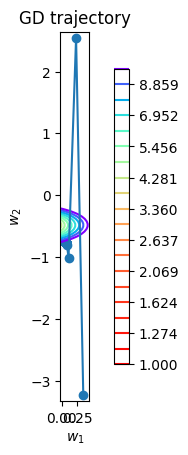

Final loss with lr=0.01 and batch_size=10: 11.48043415095196


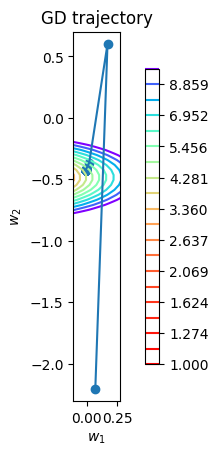

Final loss with lr=0.01 and batch_size=10: 4.519138960150878


In [292]:
batch_size = 10
n_iter = 1000
lr = 0.01
p = np.arange(0.1, 1.1, 0.1)


for i in range(len(p)):
    w_list = stochastic_gradient_descent_lr(w_init, X, y, loss, lr, batch_size,p[i] , n_iter)
    plot_gd(w_list, X, y, loss)
    print(f"Final loss with lr={lr} and batch_size={batch_size}: {loss.calc_loss(X, y, w_list[-1])}")




**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

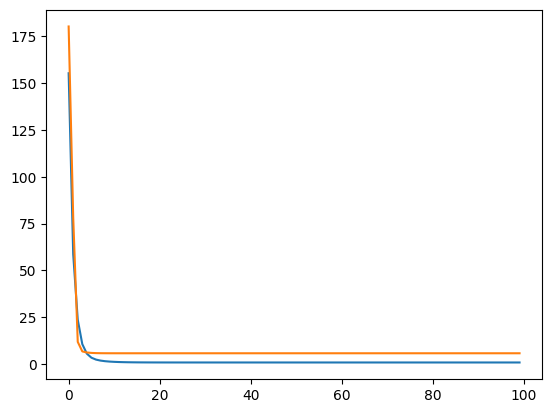

In [293]:
batch_size = 10
n_iter = 100
lr = 0.01
p = 0.4
w_1 = gradient_descent(w_init, X, y, loss, lr, n_iter)
w_2 = stochastic_gradient_descent_lr(w_init, X, y, loss, lr, batch_size,p , n_iter)
loss_list_1 = []
loss_list_2 = []
for i in range(n_iter):
    loss1 = loss.calc_loss(X, y, w_1[i])
    loss2 = loss.calc_loss(X, y, w_2[i])
    loss_list_1.append(loss1)
    loss_list_2.append(loss2)
plt.plot(range(n_iter), loss_list_1)
plt.plot(range(n_iter), loss_list_2)
plt.show()

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [294]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        w_init = np.zeros(X.shape[1])
        w = gradient_descent(w_init, X, y, self.loss, self.lr)
        self.w = w[-1] 
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        
        return np.dot(X, self.w)

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [295]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [296]:
X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [297]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)
X_raw.head()

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22


**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [302]:

cat_features_mask = (X_raw.dtypes == "object").values
X_real = X_raw[X_raw.columns[~cat_features_mask]]
X_real.columns = X_real.columns.astype(str)  # Приведение имен столбцов к строковому типу
X_no_mis_real = pd.DataFrame(data=mis_replace.fit_transform(X_real), columns=X_real.columns)
mis_replace = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(data=mis_replace.fit_transform(X_real), columns = X_real.columns)

X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

X_no_mis.head()

,index,0,1,9,10,11,12,13,16,18,...,2,3,4,5,6,7,8,14,15,17
0,0.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,1.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,2.0,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,3.0,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,4.0,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [303]:
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
X_dum

,index,0,1,9,10,11,12,13,16,18,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,0.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,False,False,False,False,False,False,False,True,False,False
1,1.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,False,False,False,False,False,False,False,True,False,False
2,2.0,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,...,False,False,False,False,False,False,False,True,False,False
3,3.0,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,...,False,False,False,False,False,False,False,True,False,False
4,4.0,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200.0,-1.0,95.0,109.1,188.8,68.9,55.5,2952.0,141.0,3.78,...,False,False,False,False,False,False,False,True,False,False
197,201.0,-1.0,95.0,109.1,188.8,68.8,55.5,3049.0,141.0,3.78,...,False,False,False,False,False,False,False,True,False,False
198,202.0,-1.0,95.0,109.1,188.8,68.9,55.5,3012.0,173.0,3.58,...,False,False,False,False,False,False,False,True,False,False
199,203.0,-1.0,95.0,109.1,188.8,68.9,55.5,3217.0,145.0,3.01,...,False,False,False,False,False,True,False,False,False,False


In [304]:
from sklearn import preprocessing

normalizer = preprocessing.MinMaxScaler()
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0.000000,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.004902,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.009804,0.6,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.014706,0.8,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.019608,0.8,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [305]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [306]:
gr = LinearRegression(MSELoss()).fit(X_train,y_train)
gr.w

array([ 10340.10695082,  -1296.1719104 ,  -1309.84992347,   4057.865806  ,
        -9097.17089724,   3924.60583595,  -2676.33581059,  21281.86391441,
         5148.54866644,  -2966.4974813 ,  -1662.87454916,  -3689.50897064,
          328.53194524,   3311.96367569,  -5771.91064431,   4762.92157917,
         2991.21448105,   5087.60299816,  -5031.54137239,  -4860.3374682 ,
        -3014.5309292 ,  -7191.63304128,   2531.74998494,  -3592.9295653 ,
        -2294.95618983,  -6836.56629664,  -6976.57797152,  -5304.59431632,
        -1730.97382081,  -9766.42617424,   5247.9637286 ,  -8321.51427284,
        -4969.33427235,  -6275.92619264, -10979.02960835, -10580.80365965,
       -12001.32413264,   5586.07350129,   2062.0552434 ,   2714.12001472,
         2154.96459822,  -2470.24618067,  -2578.4896874 ,  -2471.01609177,
        -3249.96015215,   1325.72221626,   3189.09156934,   5247.9637286 ,
        -6762.5151932 ,   1674.91553101,  -1027.96246405,  -2022.41804763,
        -5327.45986332, -

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [307]:
from sklearn.metrics import mean_squared_error

train_err = mean_squared_error(y_train, gr.predict(X_train))
test_err = mean_squared_error(y_test, gr.predict(X_test))
print ("Train: {}".format(train_err))
print ("Test: {}".format(test_err))

Train: 1268402.4984101437
Test: 9926055.385215525


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [308]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # -- YOUR CODE HERE --
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        l = y.shape[0]
        return (np.linalg.norm(np.dot(X, w) - y)**2)/l + self.coef*np.linalg.norm(w[:-1])**2
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE --
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        l = y.shape[0]
        w1 = np.copy(w)
        w1[-1] = 0
        return 2/l * X.T @ (np.dot(X, w) - y) + 2 * self.coef*w1

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [309]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [310]:
gr = linear_regression.fit(X_train,y_train)
gr.w

array([-9.67020116e+02,  5.94652627e+00, -3.99136465e+01,  1.48959226e+03,
        1.54930079e+03,  1.90255176e+03,  3.28175027e+02,  1.99107653e+03,
        2.40167492e+03,  1.05018381e+03,  5.39203479e+01,  1.45366680e+02,
        1.81975035e+03, -6.32160809e+02, -1.18445575e+03, -1.22936969e+03,
        2.84812246e+02,  8.14031785e+02, -7.50439582e+01, -3.65680639e+02,
       -2.22397473e+02, -4.40799348e+02,  1.03818759e+03, -2.20754823e+02,
        2.05800860e+03, -4.41038528e+01,  3.88372069e+01, -8.49806834e+02,
       -5.16985554e+02, -2.51394259e+02,  7.29582975e+02, -9.29896292e+01,
        4.65163604e+02, -7.64506280e+02, -1.23973434e+03, -2.91209251e+02,
        1.86987634e+02, -2.46555205e+02,  6.58578785e+02,  1.34299064e+02,
        5.79284753e+01,  1.12169292e+03, -9.51162518e+02,  2.67204888e+02,
       -7.67354933e+02, -1.09631601e+03,  1.55567963e+03,  7.29582975e+02,
       -5.92029512e+02, -2.23064719e+02, -3.49233058e+01,  1.33059521e+03,
       -3.71191219e+02,  

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [311]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        e = self.eps
        q = np.dot(X,w)-y
        loss = 0
        for i in range(len(y)):
            z = q[i]
            err = z**2/2 if np.absolute(z) < e else e*(np.absolute(z)-e/2)
            loss += err
        return loss/len(y)
        
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        e = self.eps
        q = np.dot(X,w)-y
        grad = np.zeros(len(w))
        for i in range(len(y)):
            z = q[i]
            gr = X.T[:,i]*z if np.absolute(z)<e else X.T[:,i]*e*np.sign(z)
            grad += gr
        return grad/len(y)

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [312]:
linear_regression_huber = LinearRegression(HuberLoss(0.1))

In [313]:
hl = linear_regression_huber.fit(X_train,y_train)
hl.w

array([479.5518743 , 527.57270591, 284.8082777 , 345.90816742,
       482.78842309, 454.74702172, 488.29976349, 405.05304971,
       236.33385037, 542.47630609, 539.59736857, 184.78391357,
       249.73554405, 375.41736041, 311.6537739 , 357.71359815,
        35.71428571,  35.71428571,   6.29801608,  50.08537532,
        67.66243181,  13.45506804,  14.28571429,  90.50764489,
        21.42857143,   7.14285714,  40.33394143,  88.17385286,
        64.28571429,  33.57942459,   7.14285714,   7.14285714,
        28.57142857,  53.33761666, 140.98098356,  63.24335669,
        64.28571429, 861.94342622, 185.71428571, 573.56839864,
       374.08931329,  28.57142857, 288.68029899, 460.433315  ,
       148.54409794, 527.05978675, 384.88363947,   7.14285714,
        70.58373037, 680.87922204,  60.48047381,  64.28571429,
        21.42857143,  35.71428571, 762.78826728, 107.14285714,
         6.29801608,   7.14285714,  21.42857143, 266.75192344,
        21.42857143,  92.85714286,   7.14285714, 463.24

**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2021 в ячейку ниже:

### 2021 год, вы серьезно?! Ну ладно, пошли искать. 


![Мем](https://sun9-59.userapi.com/impg/ruhpQV2v1NhfZOoG85qy6sowADFsr3Z7Ynw9vA/JPyk9Xtg4IU.jpg?size=892x920&quality=96&sign=6530c1046c1bbc3a05cef349b069a352&type=album)

### БОНУС (2.5 баллов)

Градиентный спуск — далеко не единственный метод оптимизации. 
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии. 

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [ ]:
# -- YOUR CODE HERE --